## Searchlight Analysis

How searchlight works with brainiak:

1. Initiate a searchlight object, articulating certain parameters (e.g., searchlight shape, radius, max edge length, in voxels, of the 3D block(?)).
2. Distribute to the searchlight object, sorting between MPI ranks (?).
3. Broadcast data, i.e., define other variables to be available for each execution of the searchlight function.
4. Run the searchlight, this time articulating as a parameter the function to be applied at each searchlight location.

In [145]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import numpy as np
from numpy import shape

import brainiak
import os
import json
import _pickle as cPickle

from nilearn import image
from brainiak.searchlight.searchlight import Searchlight
from brainiak.searchlight.searchlight import Diamond
from sklearn.metrics.pairwise import pairwise_distances as pd

## Setup

In [22]:
# load in experimental design pickle file
# ??? What's a pickle file? How does this represent experimental design?
with open('morph_drawing_training_design.pkl', 'rb') as f:
    mdtd = cPickle.load(f, encoding='latin1') 
    

In [148]:
## cope numbering legend
## cope1 = 'bed'
## cope2 = 'bench'
## cope3 = 'chair'
## cope4 = 'table'

cope2obj = {'cope1':'bed','cope2':'bench', 'cope3':'chair','cope4':'table'}
obj2cope = {'bed':1,'bench':2, 'chair':3,'table':4}

In [24]:
# behavioral data from database
with open('versionNums.json') as json_data:
    coll = json.load(json_data)

In [25]:
## get list of subject directories
proj_dir = '/home/jefan/sketchloop02/'
contents_dir = os.listdir(proj_dir)

sub_dirs = []
for i in contents_dir:
    try:
        if i.split('_')[1]=='neurosketch':
            sub_dirs.append(i)
    except:
        pass

sub_dirs = sorted(sub_dirs)

# issue with 1207161
sub_dirs = [s for s in sub_dirs if s != '1207161_neurosketch']

print(sub_dirs)
print(str(len(sub_dirs)) + ' subjects')

['0110171_neurosketch', '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115172_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch', '1121161_neurosketch', '1130161_neurosketch', '1201161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207162_neurosketch']
33 subjects


In [26]:
## Analysis helper functions (see and update: analysis_helpers.py)
def getEndpoints(morphline):
    # return two components 
    if morphline=='sedanMinivan':
        return ['sedan','minivan']
    elif morphline=='minivanSportscar':
        return ['minivan','sportscar']
    elif morphline=='sportscarSUV':
        return ['sportscar','SUV']
    elif morphline=='SUVMinivan':
        return ['SUV','minivan']
    elif morphline=='sportscarSedan':
        return ['sportscar','sedan']
    elif morphline=='sedanSUV':
        return ['sedan','SUV']
    elif morphline=='bedChair':
        return ['bed','chair']
    elif morphline=='bedTable':
        return ['bed','table']
    elif morphline=='benchBed':
        return ['bench','bed']
    elif morphline=='chairBench':
        return ['chair','bench']
    elif morphline=='chairTable':
        return ['chair','table']
    elif morphline=='tableBench':
        return ['table','bench']
    elif morphline=='limoToSUV':
        return ['limo','SUV']    
    elif morphline=='limoToSedan':
        return ['sedan','limo']  
    elif morphline=='limoToSmart':
        return ['limo','smartcar']  
    elif morphline=='smartToSedan':
        return ['smartcar','sedan']    
    elif morphline=='suvToSedan':
        return ['SUV','sedan']  
    elif morphline=='suvToSmart':
        return ['SUV','smartcar']  
    else:
        return ['A','B']

def load_single_run_weights(subj,run_num,cope_num):
    nifti_path = proj_dir + '/' + subj + '/analysis/firstlevel/glm4_recognition_run_' + str(run_num) + \
                '.feat/stats/' + 'cope' + str(cope_num) + '.nii.gz'
    fmri_img = image.load_img(nifti_path)
    fmri_data = fmri_img.get_data()
    return fmri_data

def get_condorder(this_sub):
    versionNum = coll[this_sub]

    design = [i for i in mdtd if i['version'] == int(versionNum)] # find which axes belong to which condition
    trained = design[0]['trained']
    near = design[0]['near']

    Tep = getEndpoints(trained)
    Nep = getEndpoints(near)
    condorder = Tep + Nep

    return (obj2cope[condorder[0]],
            obj2cope[condorder[1]],
            obj2cope[condorder[2]],
            obj2cope[condorder[3]])

In [ ]:
## look at one 
from nilearn import plotting
subj = sub_dirs[0]
run_num = 1
cope_num = 1
nifti_path = proj_dir + '/' + subj + '/analysis/firstlevel/glm4_recognition_run_' + str(run_num) + \
            '.feat/stats/' + 'cope' + str(cope_num) + '.nii.gz'
plotting.plot_img(nifti_path)
fmri_img = image.load_img(nifti_path)
fmri_data = fmri_img.get_data()
vectorized = np.ndarray.flatten(fmri_data)
thousand_random_voxels = np.random.choice(np.arange(len(vectorized)),1000)
t_map = vectorized[thousand_random_voxels]/np.std(vectorized[thousand_random_voxels])
hist = plt.hist(vectorized[thousand_random_voxels])

## Analysis

In [ ]:
# parameters
sl_rad = 1
num_copes = 4
num_runs = 2
null_mask = np.ones((94, 94, 72))

In [228]:
# define function to operate over every searchlight region
def compare_btw_wit_obj_similarity_across_runs(subject_data, mask, sl_rad, bcast_var):
    # reshape to 3D so old code can be reused
    global count
    for i in range(len(subject_data)):
        shaping = shape(subject_data[i])
        subject_data[i] = np.reshape(subject_data[i], (shaping[0], shaping[1], shaping[2]))
    
    # stack by cope for each run like roi-based function did, and then stack runs
    mat1 = np.vstack((subject_data[0].flatten(),
                     subject_data[1].flatten(),
                     subject_data[2].flatten(),
                     subject_data[3].flatten()))
    mat2 = np.vstack((subject_data[4].flatten(),
                      subject_data[5].flatten(),
                      subject_data[6].flatten(),
                      subject_data[7].flatten()))
    fAB = np.vstack((mat1, mat2))
    
    # take pairwise distance matrix life the roi-based function did and store summary statistics
    DAB = pd(fAB, metric='correlation')
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]
    wit_obj = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])].diagonal()
    btw_obj = np.hstack((offblock[np.triu_indices(shape(offblock)[0],k=1)],
                         offblock[np.tril_indices(shape(offblock)[0],k=-1)]))
    wit_mean = wit_obj.mean()
    btw_mean = btw_obj.mean()
    return wit_mean,btw_mean

In [234]:
# define function to set up and run searchlight for each in subject set
count = 0
def searchlight_over_each(subjects):
    global count
    for s in subjects:
        # set up searchlight object
        sl = Searchlight(sl_rad=sl_rad, shape=Diamond)
        
        # arrange data to be distributed to searchlight
        # list of 4D not 3D arrays
        subject_data = []
        for run in range(1, num_runs+1):
            for cope in  get_condorder(s):
                subject_data.append(np.reshape(np.array(load_single_run_weights(s, run, cope)), (94, 94, 72, 1)))
        
        # distribute and broadcast needed data to searchlight
        sl.distribute(subject_data, null_mask)
        sl.broadcast(None)
        
        # run searchlight
        subject_outputs = sl.run_searchlight(compare_btw_wit_obj_similarity_across_runs)
        
        # store output for this subject
        np.save(s + 'searchlight.npy',
                subject_outputs)

In [236]:
# time the searchlight
from timeit import default_timer as timer
start = timer()
searchlight_over_each(sub_dirs)
end = timer()
print(end - start)

ValueError: File not found: '/home/jefan/sketchloop02//1201161_neurosketch/analysis/firstlevel/glm4_recognition_run_1.feat/stats/cope4.nii.gz'

## Results/Visualization

What kinds of visualizations do we want? Big picture: we're looking to identify brain areas that can discriminate between copes. Their within-object similarity is higher than their between-object similarity. Right? But more concretely...

1. We want to observe the value distribution of values within a subject's array. Histogram.
2. We want to observe the spatial distribution of values within a subject array. Map or set of maps..?

In [280]:
# parameters
subjectindex = 2
subject = np.load(sub_dirs[subjectindex] + 'searchlight.npy')
subject = subject[~(subject == None)]


witmeans


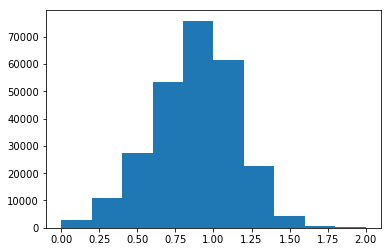

btwmeans


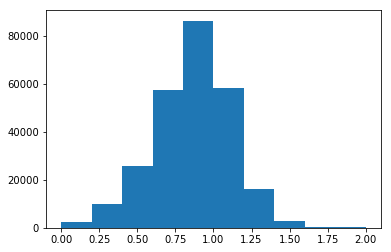

btw-wit


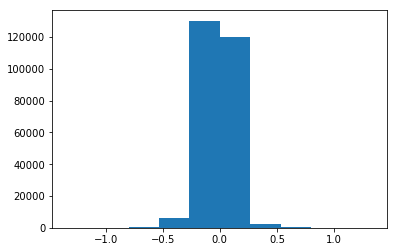

In [148]:
# histogram - value distribution
import pylab

print('witmeans')
witmeans = [cell[0] for cell in subject]
witmeans = np.array(witmeans)
pylab.figure()
pylab.hist(witmeans[~np.isnan(witmeans)])
pylab.show()

print('btwmeans')
btwmeans = [cell[1] for cell in subject]
btwmeans = np.array(btwmeans)
pylab.figure()
pylab.hist(btwmeans[~np.isnan(btwmeans)])
pylab.show()

print('btw-wit')
differences = [(cell[1] - cell[0]) for cell in subject]
differences = np.array(differences)
pylab.figure()
pylab.hist(differences[~np.isnan(differences)])
pylab.show()

In [ ]:
# for now we have just one subject to produce visualizations for
# make a difference map
difference = np.subtract(wit_means, btw_means)

# produce a histogram of the difference distribution
hist, bin_edges = np.histogram(np.reshape(difference, difference.size))
plt.hist(hist, bins='auto')
plt.title("Difference Distribution")
plt.show()
    

In [136]:
np.nan

nan